In [ ]:
import numpy as np
import faiss
import glob
import json
import matplotlib.pyplot as plt
import os
import math
import torch
import pandas as pd
import re

from langdetect import detect
from PLIPmodel import Create_PLIP_Model
from transformers import BertTokenizer


In [ ]:
class File4Faiss:
  def __init__(self, root_database: str):
    self.root_database = root_database

  def re_shot_list(self, shot_list, id, k):
    len_lst = len(shot_list)
    if k>=len_lst or k == 0:
      return shot_list

    shot_list.sort()
    index_a = shot_list.index(id)

    index_get_right = k // 2
    index_get_left = k - index_get_right

    if index_a - index_get_left < 0:
      index_get_left = index_a
      index_get_right = k - index_a
    elif index_a + index_get_right >= len_lst:
      index_get_right = len_lst - index_a - 1
      index_get_left = k - index_get_right

    output = shot_list[index_a - index_get_left: index_a] + shot_list[index_a: index_a + index_get_right + 1]
    return output

  def write_json_file(self, json_path: str, shot_frames_path: str, option='full'):
    count = 0
    self.infos = []
    des_path = os.path.join(json_path, "keyframes_id.json")
    keyframe_paths = sorted(glob.glob(f'{self.root_database}/KeyFramesC0*'))

    for kf in keyframe_paths:
      video_paths = sorted(glob.glob(f"{kf}/*"))

      for video_path in video_paths:
        image_paths = sorted(glob.glob(f'{video_path}/*.jpg'))

        ###### Get all id keyframes from video_path ######
        id_keyframes = np.array([int(id.split('/')[-1].replace('.jpg', '')) for id in image_paths])

        ###### Get scenes from video_path ######
        video_info = video_path.split('/')[-1]
        
        with open(f'{shot_frames_path}/{video_info}.txt', 'r') as f:
          lst_range_shotes = f.readlines()
        lst_range_shotes = np.array([re.sub('\[|\]', '', line).strip().split(' ') for line in lst_range_shotes]).astype(np.uint32)

        for im_path in image_paths:
          # im_path = 'Database/' + '/'.join(im_path.split('/')[-3:])
          id = int(im_path.split('/')[-1].replace('.jpg', ''))
          
          i = 0
          flag=0
          for range_shot in lst_range_shotes:
            i+=1
            first, end = range_shot

            if first <= id <= end:
              break
            
            if i == len(lst_range_shotes):
              flag=1
          
          if flag == 1:
            print(f"Skip: {im_path}")
            print(first, end)
            continue

          ##### Get List Shot ID #####
          lst_shot = id_keyframes[np.where((id_keyframes>=first) & (id_keyframes<=end))]
          lst_shot = self.re_shot_list(list(lst_shot), id, k=6)
          lst_shot = [f"{i:0>6d}" for i in lst_shot]

          ##### Get List Shot Path #####
          lst_shot_path = []
          for id_shot in lst_shot:
            info_shot = {
                "shot_id": id_shot,
                "shot_path": '/'.join(im_path.split('/')[:-1]) + f"/{id_shot}.jpg"
            }
            lst_shot_path.append(info_shot) 

          ##### Merge All Info #####
          info = {
                  "image_path": im_path,
                  "list_shot_id": lst_shot,
                  "list_shot_path": lst_shot_path
                 }
                  
          if option == 'full':        
            self.infos.append(info)   
          else:
            if id == (end+first)//2:
              self.infos.append(info)  

          count += 1

    id2img_fps = dict(enumerate(self.infos))
    
    with open(des_path, 'w') as f:
      f.write(json.dumps(id2img_fps))

    print(f'Saved {des_path}')
    print(f"Number of Index: {count}")

  def load_json_file(self, json_path: str):
    with open(json_path, 'r') as f:
      js = json.loads(f.read())

    return {int(k):v for k,v in js.items()}

  def write_bin_file(self, bin_path: str, json_path: str, method='L2', feature_shape=768): # Edit 512, 768
    count = 0
    id2img_fps = self.load_json_file(json_path)

    if method in 'L2':
      index = faiss.IndexFlatL2(feature_shape)
    elif method in 'cosine':
      index = faiss.IndexFlatIP(feature_shape)
    else:
      assert f"{method} not supported"
    
    for _, value in id2img_fps.items():
      image_path = value["image_path"]
      video_name = image_path.split('/')[-2] + '.npy'

      video_id = re.sub('_V\d+', '', image_path.split('/')[-2])
      batch_name = image_path.split('/')[-3].split('_')[-1]
      clip_name = f"PLIP_Features" # Edit 

      feat_path = os.path.join(self.root_database, clip_name, video_name) 

      feats = np.load(feat_path)

      ids = os.listdir(re.sub('/\d+.jpg','',image_path))
      ids = sorted(ids, key=lambda x:int(x.split('.')[0]))

      id = ids.index(image_path.split('/')[-1])
      
      feat = feats[id]
      print(feat.shape)
      feat = feat.astype(np.float32).reshape(1,-1)
      print("##########################################")
      print(" Feat after reshape: ", feat.shape)
      index.add(feat)
      
      count += 1
    
    faiss.write_index(index, os.path.join(bin_path, f"faiss_PLIP_{method}.bin"))

    print(f'Saved {os.path.join(bin_path, f"faiss_PLIP_{method}.bin")}')
    print(f"Number of Index: {count}")

In [ ]:
create_file = File4Faiss('data')
create_file.write_json_file(json_path='data/faiss_merge_files', shot_frames_path='data/scenes_txt')
create_file.write_bin_file(bin_path='data/faiss_merge_files', json_path='data/faiss_merge_files/keyframes_id.json', method='cosine')

Saved data/faiss_merge_files/keyframes_id.json
Number of Index: 2299
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
##########################################
 Feat after reshape:  (1, 768)
(768,)
#################################

In [ ]:
class MyFaiss:
  def __init__(self, root_database: str, bin_file: str, json_path: str):    
    self.index = self.load_bin_file(bin_file)
    self.id2img_fps = self.load_json_file(json_path)

    self.translater = Translation()
    

    ################################################### Load model encode text PLIP ###################################################
    self.__device = "cuda" if torch.cuda.is_available() else "cpu"
    self.checkpoint = torch.load("checkpoints/PLIP_RN50.pth.tar",map_location='cpu')

    self.model = Create_PLIP_Model().to(self.__device)
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    ####################################################################################################################################
  def load_json_file(self, json_path: str):
      with open(json_path, 'r') as f:
        js = json.loads(f.read())

      return {int(k):v for k,v in js.items()}

  def load_bin_file(self, bin_file: str):
    return faiss.read_index(bin_file)

  def show_images(self, image_paths):
    fig = plt.figure(figsize=(15, 10))
    columns = int(math.sqrt(len(image_paths)))
    rows = int(np.ceil(len(image_paths)/columns))

    for i in range(1, columns*rows +1):
      img = plt.imread(image_paths[i - 1])
      ax = fig.add_subplot(rows, columns, i)
      ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

      plt.imshow(img)
      plt.axis("off")
      
    plt.show()

  def image_search(self, id_query, k):    
    query_feats = self.index.reconstruct(id_query).reshape(1,-1)

    scores, idx_image = self.index.search(query_feats, k=k)
    idx_image = idx_image.flatten()

    infos_query = list(map(self.id2img_fps.get, list(idx_image)))
    image_paths = [info['image_path'] for info in infos_query]
    
    # print(f"scores: {scores}")
    # print(f"idx: {idx_image}")
    # print(f"paths: {image_paths}")
    
    return scores, idx_image, infos_query, image_paths

  def text_search(self, text, k):
    if detect(text) == 'vi':
      text = self.translater(text)

    ################################################# Edit encode text for PLIP #################################################
    self.model.text_encoder.load_state_dict(self.checkpoint["TxtEncoder_state_dict"])
    self.model = self.model.eval()
    ###### TEXT FEATURES EXACTING ######
    result = self.tokenizer(text, padding="max_length", max_length=64, truncation=True, return_tensors='pt').to(self.__device)
    token, mask = result["input_ids"], result["attention_mask"]
    with torch.no_grad():
        text_feat = self.model.get_text_global_embedding(token,mask)
    text_features = text_feat.cpu().detach().numpy().astype(np.float32)

    #############################################################################################################################


    
    ###### SEARCHING #####
    scores, idx_image = self.index.search(text_features, k=k)
    idx_image = idx_image.flatten()

    ###### GET INFOS KEYFRAMES_ID ######
    infos_query = list(map(self.id2img_fps.get, list(idx_image)))
    image_paths = [info['image_path'] for info in infos_query]
    # lst_shot = [info['list_shot_id'] for info in infos_query]

    # print(f"scores: {scores}")
    # print(f"idx: {idx_image}")
    # print(f"paths: {image_paths}")

    return scores, idx_image, image_paths

  def write_csv(self, infos_query, des_path):
    check_files = []
    
    ### GET INFOS SUBMIT ###
    for info in infos_query:
      video_name = info['image_path'].split('/')[-2]
      lst_frames = info['list_shot_id']

      for id_frame in lst_frames:
        check_files.append(os.path.join(video_name, id_frame))
    ###########################
    
    check_files = set(check_files)

    if os.path.exists(des_path):
        df_exist = pd.read_csv(des_path, header=None)
        lst_check_exist = df_exist.values.tolist()      
        check_exist = [info[0].replace('.mp4','/') + f"{info[1]:0>6d}" for info in lst_check_exist]

        ##### FILTER EXIST LINES FROM SUBMIT.CSV FILE #####
        check_files = [info for info in check_files if info not in check_exist]
    else:
      check_exist = []

    video_names = [i.split('/')[0] + '.mp4' for i in check_files]
    frame_ids = [i.split('/')[-1] for i in check_files]

    dct = {'video_names': video_names, 'frame_ids': frame_ids}
    df = pd.DataFrame(dct)

    if len(check_files) + len(check_exist) < 99:
      df.to_csv(des_path, mode='a', header=False, index=False)
      print(f"Save submit file to {des_path}")
    else:
      print('Exceed the allowed number of lines')

In [ ]:
import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


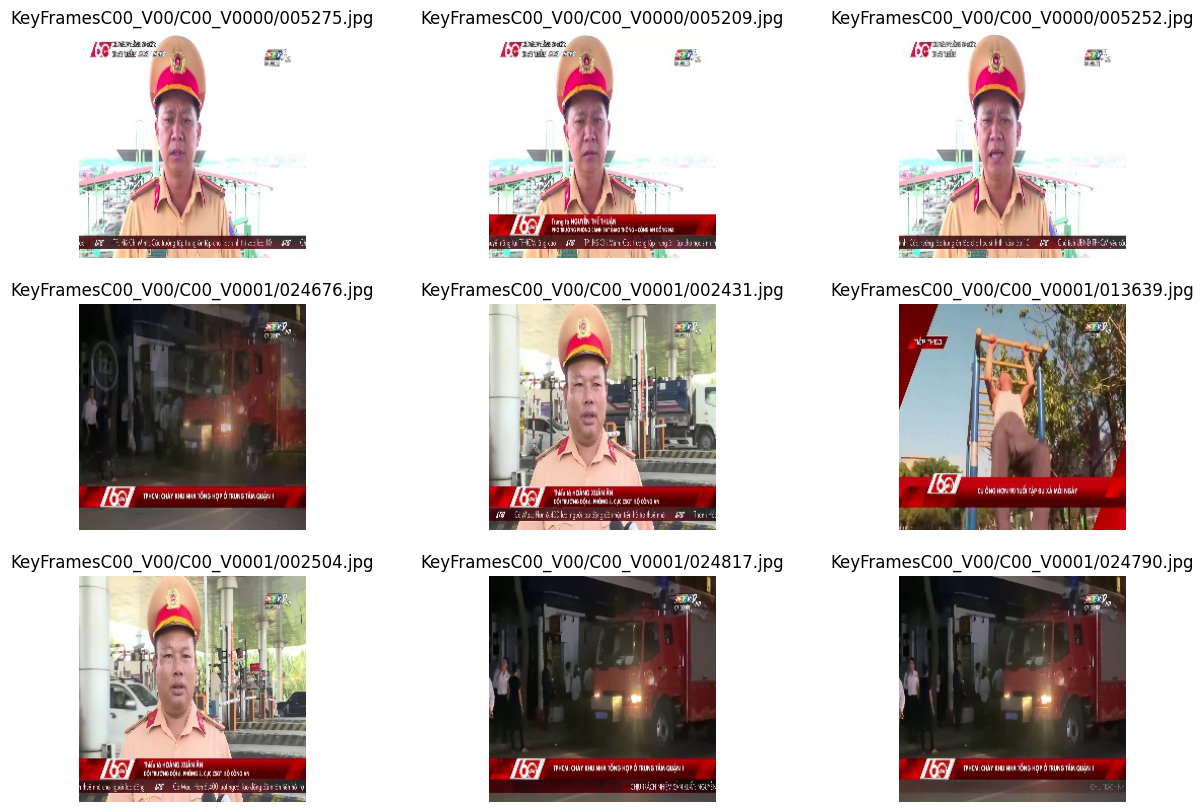

In [ ]:
def main():
  ##### CREATE JSON AND BIN FILES #####
  # create_file = File4Faiss('./Database')
  # create_file.write_json_file(json_path='./', shot_frames_path='./scenes_txt')
  # create_file.write_bin_file(bin_path='./', json_path='./keyframes_id.json', method='cosine')

  ##### TESTING #####
  bin_file='data/faiss_merge_files/faiss_PLIP_cosine.bin'
  json_path = 'data/faiss_merge_files/keyframes_id.json'

  cosine_faiss = MyFaiss('./Database', bin_file, json_path)

  ##### IMAGE SEARCH #####
  # i_scores, infos_query, i_image_paths = cosine_faiss.text_search(id_query=9999, k=9)
  # # cosine_faiss.write_csv(infos_query, des_path_submit='./')
  # cosine_faiss.show_images(i_image_paths)

  ##### TEXT SEARCH #####
  text = 'MC đang dẫn chương'

  scores, infos_query, image_paths = cosine_faiss.text_search(text, k=9)
  # cosine_faiss.write_csv(infos_query, des_path_submit='./')
  cosine_faiss.show_images(image_paths)

if __name__ == "__main__":
    main()